This notebook will take in a list of questions and calculate sentence similarity scores between each of them using the BERT model. We will begin by importing the dataset itself below. Credit for the "how-to" and code below goes to this [fantastic article](https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1). The main instruction is that the column with the text must be called 'text' for this script to work.

In [17]:
# Constants
dev = False
dataset = 'chinese_proverbs' # https://www.kaggle.com/bryanb/scraping-sayings-and-proverbs
column = 'text' # text
model_name = 'all-mpnet-base-v2' #'dmis-lab/biobert-base-cased-v1.2' #'multi-qa-mpnet-base-dot-v1' # all-mpnet-base-v2
cutoff = 0.6 # Note that cutoffs differ depending on the model used. 0.5 for all-mpnet-base-v2

In [18]:
import pandas as pd
dat = pd.read_csv('../data/processed/' + dataset + '.csv')

if dev == True:
    dat = dat.head(100)
    
display(dat.shape)
display(dat)

(127, 6)

,Unnamed: 0,in_chinese,pin_yin,text,category,origin
0,0,不作不死。,Bù zuò bù sǐ. 'Not do not die.',If you don't do stupid things you won't end up in tragedy.,Wisdom,Chinese
1,1,塞翁失马，焉知非福。,"Sài Wēng shī mǎ, yān zhī fēi fú. 'Sai Weng [legendary old man's name] lost horse, how know not blessing'.",Blessings come in disguise.,Wisdom,Chinese
2,2,小洞不补，大洞吃苦。,"Xiǎodòng bù bǔ, dàdòng chī kǔ.'small hole not mend; big hole eat hardship'","If small holes aren't fixed, then big holes will bring hardship.",Wisdom,Chinese
3,3,水满则溢。,Shuǐmǎn zé yì. 'water full but overflows',Water flows in only to flow out.,Wisdom,Chinese
4,4,读万卷书不如行万里路。,"Dú wànjuànshū bù rú xíng wànlǐlù. 'reading 10,000 books, not as good as walking 10,000 li road'",It's better to walk thousands of miles than to read thousands of books.,Wisdom,Chinese
...,...,...,...,...,...,...
122,122,龙潭虎穴。,Lóng tán hǔ xué. 'dragon pool tiger cave',A dragon's pool and a tiger's den.,Dragons,Chinese
123,123,画龙点睛。,Huàlóngdiǎnjīng. 'paint dragon dot eye',Paint a dragon and dot the eye.,Dragons,Chinese
124,124,叶公好龙。,Yè Gōng hào long.,Lord Ye loves dragons.,Dragons,Chinese
125,125,鲤鱼跳龙门。,Lǐyú tiào lóng mén. 'carp jump dragon gate',A carp has jumped the dragon's gate.,Dragons,Chinese


In [19]:
# Optional block where you filter and modify the dataset to fit your needs 
#d = {column: dat[column], 'links': dat[column + '_links']}
#dat = pd.DataFrame(data=d)
#display(dat)

Now we will isolate the questions as an array of sentences, which will be fed into a pre-trained user-specified model. We note that there was a "module not found" error in the code below. The maintainer of the sentence-transformers package fixed it and requires the user to install via "pip install -U sentence-transformers." The code below takes a while to run, as the pre-trained model is quite large. A menu of models is [here](https://www.sbert.net/docs/pretrained_models.html)

In [20]:
from sentence_transformers import SentenceTransformer

sentences = dat[column].tolist()
model = SentenceTransformer(model_name)

sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


(127, 768)

TODO Here, we make a topic model for our sentence similarity embedding. We will use the BERTopic library, [here](https://maartengr.github.io/BERTopic/index.html#quick-start)

From here, we're going to use cosine similarity to determine which questions are most similar to each other. One example of this is below. We compare the initial question to the first five questions after the initial question. We will display the questions and the similarity scores and see if it makes sense. 

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cos_sim = cosine_similarity(
    [sentence_embeddings[20]],
    sentence_embeddings
).tolist()

df = pd.DataFrame({'text': sentences,
            'similarity': cos_sim[0]})

# Arrange by similarity
pd.set_option('display.max_colwidth', None)
display(df.sort_values(by = 'similarity', ascending = False))

,text,similarity
20,"If people are of one heart, even loess can become gold.",1.000000
15,No man is a perfect man; no gold is sufficiently bare.,0.472072
29,Fate brings people together from far apart.,0.428726
42,People in love become spouses in the end.,0.390039
32,In hardship we see true friendship.,0.369821
...,...,...
122,A dragon's pool and a tiger's den.,0.055180
108,Like sitting on a carpet of needles.,0.044318
116,The quick footed climb first.,0.035367
99,Deliberately vague and deflective.,-0.006617


We were going to run a UMAP on the vector space to get some intuition around what it looks like, but because UMAP has issues with python 3.9 at the moment, we're going to jump right to making a cosine similarity matrix that we will then turn into a graph. 

In [22]:
import sklearn

dist = sklearn.metrics.pairwise.cosine_distances(sentence_embeddings)
dist

# nn = sklearn.neighbors.kneighbors_graph(sentence_embeddings, n_neighbors = 1)
# nn

array([[0.        , 0.72029793, 0.7724668 , ..., 0.89397776, 0.9592389 ,
        0.84870195],
       [0.72029793, 0.        , 0.7582819 , ..., 0.80537313, 1.0062431 ,
        0.8649641 ],
       [0.7724668 , 0.7582819 , 0.        , ..., 0.9491456 , 1.021123  ,
        0.816676  ],
       ...,
       [0.89397776, 0.80537313, 0.9491456 , ..., 0.        , 0.7197591 ,
        0.6200161 ],
       [0.9592389 , 1.0062431 , 1.021123  , ..., 0.7197591 , 0.        ,
        0.74940705],
       [0.84870195, 0.8649641 , 0.816676  , ..., 0.6200161 , 0.74940705,
        0.        ]], dtype=float32)

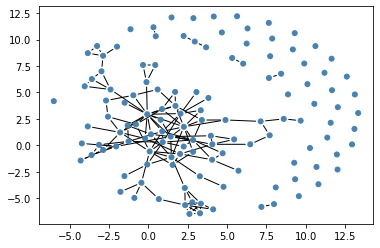

In [23]:
import igraph as ig
import matplotlib.pyplot as plt

dist = np.where(dist == 0, 1, dist) # For the boolean below. Can't figure out compound boolean.

g = ig.Graph.Adjacency(dist < cutoff) # Need to convert to boolean
g = g.as_undirected()

if dat.shape[0] <= 1000:
    fig, ax = plt.subplots()
    ig.plot(g, target=ax)

Now we will do a quick measure of betweenness and eigenvector centrality to get a feel for what questions are the most central. We'll print the top 10 of each.

In [24]:
deg = g.degree()
btw = g.betweenness()
dat['degree'] = g.degree()
dat['betweenness'] = g.betweenness()
display(dat.sort_values(by='degree', ascending=False))
display(dat.sort_values(by='betweenness', ascending=False))

,Unnamed: 0,in_chinese,pin_yin,text,category,origin,degree,betweenness
109,109,逆来顺受。,Nì lái shùn shòu. 'adversity come follow receive',"When adversity comes, receive it favorably.",Literature,Chinese,16,1143.134694
29,29,有缘千里来相会。,"Yǒuyuán qiānlǐ lái xiānghuì. 'Have fate 1,000 li [or a long way] together meet'",Fate brings people together from far apart.,Friendship,Chinese,11,612.397998
32,32,患难见真情。,Huànnàn jiàn zhēnqíng 'Hardship see true situation',In hardship we see true friendship.,Friendship,Chinese,9,571.870434
80,80,一寸光阴一寸金，寸金难买寸光阴。,"Yícùn guāngyīn yícùnjīn, cùnjīn nán mǎi cùnguāngyīn. '1 cun [Chinese inch, 1/30 m] time 1 cun gold, cun gold difficult buy cun time'","An inch of time is worth an inch of gold, but an inch of gold may not buy an inch of time.",Education,Chinese,8,455.118473
37,37,愿得一人心，白首不相离。,"Yuàndé yīrénxīn, báishǒu bùxiānglí. 'wish get a person heart, white head not one-another apart","Long for a heart, never be apart.",Love,Chinese,8,221.228632
...,...,...,...,...,...,...,...,...
44,44,爱之深，责之切。,"Ài zhī shēn zé zhī qiē. 'love's deep, discipline's cutting'","Love deep, chastise deep.",Love,Chinese,0,0.000000
40,40,萝卜青菜，各有所爱。,"Luóbo qīngcài, gè yǒu suǒ ài. 'radishes greens, each have that-which loves'","Radishes and greens, each have those who love them.",Love,Chinese,0,0.000000
99,99,顾左右而言他。,Gù zuǒyòu ér yán tā. 'deliberately approximate and talk something-else',Deliberately vague and deflective.,Literature,Chinese,0,0.000000
102,102,万事俱备，只欠东风。,"Wànshì jù bèi, zhǐ qiàn dōngfēng. 'all ready, only lack east wind'",Everything's ready except the east wind.,Literature,Chinese,0,0.000000


,Unnamed: 0,in_chinese,pin_yin,text,category,origin,degree,betweenness
109,109,逆来顺受。,Nì lái shùn shòu. 'adversity come follow receive',"When adversity comes, receive it favorably.",Literature,Chinese,16,1143.134694
89,89,路遥知马力，日久见人心。,"Lùyáo zhī mǎlì, rìjiǔ jiàn rénxīn. 'road distant know horse strength, days old see man heart'","As distance tests a horse's strength, time reveals a person's character.",Literature,Chinese,7,686.780771
29,29,有缘千里来相会。,"Yǒuyuán qiānlǐ lái xiānghuì. 'Have fate 1,000 li [or a long way] together meet'",Fate brings people together from far apart.,Friendship,Chinese,11,612.397998
32,32,患难见真情。,Huànnàn jiàn zhēnqíng 'Hardship see true situation',In hardship we see true friendship.,Friendship,Chinese,9,571.870434
6,6,一笑解千愁。,"Yī xiào jiě qiānchou. 'one smile undoes 1,000 worries'",A smile dispels many worries.,Wisdom,Chinese,4,485.500000
...,...,...,...,...,...,...,...,...
54,54,不当家，不知柴米贵。,"Bù dānɡjiā，bù zhī cháimǐ ɡuì. 'Not manage household, not know firewood rice precious'","If you don't run the family, you don't know the value of fuel and rice.",Family,Chinese,1,0.000000
47,47,儿行千里母担忧。,"Er xíng qiānlǐ mǔ dānyōu. 'son travels 1,000 li [a long way; 500 km] mother worries'","When children travel far, mothers worry.",Family,Chinese,1,0.000000
46,46,月到中秋分外明，每逢佳节倍思亲。,"Yuè dào zhōngqiū fènwài míng, měi féng jiājié bèi sīqīn. 'moon reach Mid-Autumn exceptionally bright, every holiday multiply homesick'",The harvest moon is brightest; every festival homesickness multiplies.,Family,Chinese,1,0.000000
45,45,有情饮水饱，无情食饭饥。,"Yǒuqínɡ yínshuǐbǎo, wúqínɡ shífànjī. 'Have affection drink water full; no affection eat food hungry'",With love water is enough; without love food doesn't satisfy.,Love,Chinese,2,0.000000


From here, we run clustering to see if the the quesitons group into particular themes. We will use Louvain clustering, as it is often used in graph-based analysis.

In [25]:
clust = ig.Graph.community_multilevel(g)
#df = pd.DataFrame({'name': dat['Question'], 'cluster': clust.membership})
dat['cluster'] = clust.membership

# Get cluster ID, mine the per-cluster topics
for i in pd.unique(dat['cluster']):
    curr = dat[dat['cluster'] == i]
    if curr.shape[0] > 5:
        display(curr.sort_values(by='degree', ascending=False))
        

,Unnamed: 0,in_chinese,pin_yin,text,category,origin,degree,betweenness,cluster
29,29,有缘千里来相会。,"Yǒuyuán qiānlǐ lái xiānghuì. 'Have fate 1,000 li [or a long way] together meet'",Fate brings people together from far apart.,Friendship,Chinese,11,612.397998,0
9,9,不善始者不善终。,Bú shànshǐzhě bù shànzhōng. 'not good starter not good end',A bad beginning makes a bad ending.,Wisdom,Chinese,7,119.754889,0
60,60,失败是成功之母。,Shībài shì chénggōng zhī mǔ. 'failure is success's mother',Failure is the mother of success.,Encouragement,Chinese,7,197.356638,0
0,0,不作不死。,Bù zuò bù sǐ. 'Not do not die.',If you don't do stupid things you won't end up in tragedy.,Wisdom,Chinese,5,45.304149,0
42,42,有情人终成眷属。,Yǒuqínɡrén zhōnɡ chénɡ juànshǔ. 'in-love people finally become spouses',People in love become spouses in the end.,Love,Chinese,4,28.409524,0
49,49,家和万事兴。,Jiāhé wànshìxīnɡ. 'family harmonious everything prospers',If a family is harmonious everything will go well.,Family,Chinese,3,232.975000,0
19,19,祸从口出。,Huò cóng kǒu chū. 'disaster from mouth exits',Disaster comes from careless talk.,Wisdom,Chinese,2,0.000000,0
52,52,有其父，必有其子。,"Yǒuqífù，bìyǒuqízǐ. 'have his father, must have his son'","Where there's a father, there's his son.",Family,Chinese,2,7.593417,0
25,25,欲速则不达。,Yù sù zé bùdá. 'Desire speed but not attain.',Those who just want speed don't succeed.,Wisdom,Chinese,1,0.000000,0
69,69,先到先得。,Xiān dào xiān dé. 'first arrive first get',The first to arrive is the first to succeed.,Encouragement,Chinese,1,0.000000,0


,Unnamed: 0,in_chinese,pin_yin,text,category,origin,degree,betweenness,cluster
109,109,逆来顺受。,Nì lái shùn shòu. 'adversity come follow receive',"When adversity comes, receive it favorably.",Literature,Chinese,16,1143.134694,1
32,32,患难见真情。,Huànnàn jiàn zhēnqíng 'Hardship see true situation',In hardship we see true friendship.,Friendship,Chinese,9,571.870434,1
94,94,有理走遍天下，无理寸步难行。,"Yǒulǐ zǒubiàn tiānxià, wúlǐ cùnbù nánxíng. 'have truth walk all land-under-heaven; no truth cun [Chinese inch; 1/30 m] step difficult walk'","With truth on your side, you can go anywhere; without truth, you can't take a tiny step.",Literature,Chinese,7,265.469622,1
89,89,路遥知马力，日久见人心。,"Lùyáo zhī mǎlì, rìjiǔ jiàn rénxīn. 'road distant know horse strength, days old see man heart'","As distance tests a horse's strength, time reveals a person's character.",Literature,Chinese,7,686.780771,1
115,115,大智若愚。,Dàzhì ruò yú. 'great wisdom seem stupid',Great wisdom can seem foolish.,Literature,Chinese,6,96.787111,1
72,72,吃一堑，长一智。,"Chī yīqiàn, zhǎng yízhì. 'eat a moat, grow a wisdom'","Suffer a moat, grow in wisdom.",Encouragement,Chinese,4,21.949568,1
68,68,吃得苦中苦，方为人上人。,"Chī dé kǔzhōngkǔ, fāng wéi rénshàngrén. 'eat gain pain in pain, method for man on man'",Enduring deepening pain is how man ascends.,Encouragement,Chinese,4,76.969701,1
83,83,学而不思则罔，思而不学则殆。,"Xué ér bùsī zé wǎng, sī ér bùxué zé dài. 'study but not think then deceive, think but not study then dangerous'",Learning without thought is deceptive; thought without learning is perilous.,Education,Chinese,3,23.944351,1
1,1,塞翁失马，焉知非福。,"Sài Wēng shī mǎ, yān zhī fēi fú. 'Sai Weng [legendary old man's name] lost horse, how know not blessing'.",Blessings come in disguise.,Wisdom,Chinese,3,67.332272,1
21,21,身正不怕影子斜。,Shēnzhèng búpà yǐngzi xié. 'body straight not fear shadow slanting',One who stands straight doesn't fear a crooked shadow.,Wisdom,Chinese,3,40.903175,1


,Unnamed: 0,in_chinese,pin_yin,text,category,origin,degree,betweenness,cluster
4,4,读万卷书不如行万里路。,"Dú wànjuànshū bù rú xíng wànlǐlù. 'reading 10,000 books, not as good as walking 10,000 li road'",It's better to walk thousands of miles than to read thousands of books.,Wisdom,Chinese,6,121.468056,4
79,79,好书如挚友。,Hǎoshū rú zhìyǒu. 'good book as-good-as close-friend',A good book is like a good friend.,Education,Chinese,5,178.071429,4
27,27,听君一席话，胜读十年书。,"Tīng jūn yīxíhuà, shèng dú shíniánshū 'hear gentleman remarks, beats reading ten year books'",Listening to a lord's remarks is better than reading books for ten years.,Friendship,Chinese,4,7.127778,4
84,84,书到用时方恨少。,Shū dào yòngshí fāng hènshǎo. 'books till use time just-when hate few',"When using books, you'll regret reading few.",Education,Chinese,4,10.867460,4
85,85,读书须用意，一字值千金。,"dúshū xū yòngyì, yīzì zhí qiānjīn. 'reading books needs use attention, one word worth 1,000 gold'",Reading requires concentration; a word may be worth a fortune.,Education,Chinese,2,0.000000,4
77,77,书是随时携带的花园。,Shū shì suíshí xiédài de huāyuán. 'book is at-all-times carried garden',A book is a pocket garden.,Education,Chinese,1,0.000000,4


,Unnamed: 0,in_chinese,pin_yin,text,category,origin,degree,betweenness,cluster
6,6,一笑解千愁。,"Yī xiào jiě qiānchou. 'one smile undoes 1,000 worries'",A smile dispels many worries.,Wisdom,Chinese,4,485.5,6
48,48,但愿人长久，千里共婵娟。,"Dànyuàn rénchángjiǔ, qiānlǐ gòngchánjuān. 'Yet wish personlong-time, 1,000 li [a long way; 500 km] share moon[beauty]'","Wishing us long life, though sharing moonlight from afar.",Family,Chinese,4,221.0,6
100,100,几家欢喜几家愁。,Jǐjiā huānxǐ jǐjiā chou. 'few families happy few families worried',"While some are happy, some are anxious.",Literature,Chinese,3,2.5,6
106,106,人逢喜事精神爽。,Rén féng xǐshì jīngshén shuǎng. 'man meet happy-occasion spirit invigorated',A happy occasion gladdens the spirit.,Literature,Chinese,3,288.0,6
7,7,"笑一笑,十年少。","Xiào yī xiào, shínián shào. 'laugh,ten years younger'",Happiness is the best cosmetic.,Wisdom,Chinese,2,0.0,6
70,70,守得云开见月明。,Shǒu dé yún kāi jiàn yuèmíng. 'keep-watch gain cloud open see moonlight',Watch till clouds part to see moonlight.,Encouragement,Chinese,2,0.0,6
75,75,星星之火，可以燎原。,"Xīngxīng zhī huǒ, kěyǐ liáoyuan. 'star's fire, can shine far'",Starlight shines far.,Encouragement,Chinese,2,0.0,6
46,46,月到中秋分外明，每逢佳节倍思亲。,"Yuè dào zhōngqiū fènwài míng, měi féng jiājié bèi sīqīn. 'moon reach Mid-Autumn exceptionally bright, every holiday multiply homesick'",The harvest moon is brightest; every festival homesickness multiplies.,Family,Chinese,1,0.0,6


,Unnamed: 0,in_chinese,pin_yin,text,category,origin,degree,betweenness,cluster
37,37,愿得一人心，白首不相离。,"Yuàndé yīrénxīn, báishǒu bùxiānglí. 'wish get a person heart, white head not one-another apart","Long for a heart, never be apart.",Love,Chinese,8,221.228632,11
80,80,一寸光阴一寸金，寸金难买寸光阴。,"Yícùn guāngyīn yícùnjīn, cùnjīn nán mǎi cùnguāngyīn. '1 cun [Chinese inch, 1/30 m] time 1 cun gold, cun gold difficult buy cun time'","An inch of time is worth an inch of gold, but an inch of gold may not buy an inch of time.",Education,Chinese,8,455.118473,11
57,57,机不可失，时不再来。,"Jī bùkě shī, shí búzài lái. 'Opportunity can't lose, time not again come'",Don't miss opportunities: time doesn't come round again.,Encouragement,Chinese,7,178.882574,11
82,82,花有重开日，人无再少年。,"Huā yǒu chóng kāi rì, rén wú zài shào nián. 'flower has again open day, people no again youth'",Flowers may bloom again; you're never young again.,Education,Chinese,7,146.760976,11
28,28,"凡人不可貌相, 海水不可斗量。","Fánrén bù kě màoxiàng, hǎishuǐ bù kě dòuliàng. 'mortals can't judge by appearance, sea water can't cup measure'",Man cannot be judged by looks; seas cannot be measured by cup.,Friendship,Chinese,5,111.386858,11
78,78,活到老，学到老。,"Huó dào lǎo, xué dào lǎo. 'live till old, study till old.","Live till you're old, and study till you're old.",Education,Chinese,5,71.094643,11
43,43,情人眼里出西施。,Qínɡrén yǎnlǐ chū xīshī. 'lover eye inside appears Xishi [name; foremost of the Four Legendary Chinese Beauties],In a lover's eye is the foremost Beauty.,Love,Chinese,4,85.867063,11
15,15,人无完人，金无足赤。,"Rén wú wánrén, jīn wú zúchì. 'man lackperfect man; gold lack enoughred'",No man is a perfect man; no gold is sufficiently bare.,Wisdom,Chinese,3,11.770635,11
96,96,十年树木，百年树人。,"Shínián shù mù, bǎinián shù rén. '10 years cultivate wood, 100 years cultivate man'","Ten years to cultivate wood, a hundred years to cultivate a man.",Literature,Chinese,3,87.196785,11
20,20,三人一条心，黄土变成金。,"Sānrén yìtiáoxīn, huángtǔ biàn chéng jīn. 'three people one heart; yellow earth become gold'","If people are of one heart, even loess can become gold.",Wisdom,Chinese,2,14.720635,11


,Unnamed: 0,in_chinese,pin_yin,text,category,origin,degree,betweenness,cluster
120,120,龙腾虎跃。,Lóng téng hǔ yuè. 'dragon soars tiger leaps',Dragons soaring and tigers leaping.,Dragons,Chinese,7,115.084729,12
119,119,鱼龙混杂。,Yú lóng hùnzá. 'fish dragons muddle mix',A muddled mix of fish and dragons.,Dragons,Chinese,6,75.453271,12
118,118,龙马精神。,Lóng mǎ jīngshén. 'dragon horse spirit',A dragon's and a horse's spirit.,Dragons,Chinese,5,42.589779,12
14,14,一鸟在手胜过双鸟在林。,Yī niǎo zài shǒu shèng guò shuāng niǎo zài lín 'one bird in hand beats pair birds in forest',A bird in the hand is worth than two in the bush.,Wisdom,Chinese,4,225.728500,12
117,117,龙飞凤舞。,Lóng fēi fèn gwǔ. 'dragon flies phoenix dances',The dragon flies and the phoenix dances.,Dragons,Chinese,4,0.000000,12
121,121,车水马龙。,Chē shuǐ mǎ long. 'carriage water horse dragon',Carriages like a stream and horses like a dragon.,Dragons,Chinese,4,385.271500,12
122,122,龙潭虎穴。,Lóng tán hǔ xué. 'dragon pool tiger cave',A dragon's pool and a tiger's den.,Dragons,Chinese,4,0.000000,12
41,41,在天愿作比翼鸟，在地愿为连理枝。,"Zài tiān yuàn zuò bǐyìniǎo, zài dì yuàn wéi liánlǐzhī. 'in sky wish be fly-wing-to-wing birds; on earth wish be grow-together branches.",Birds flying in the sky as one; branches growing on the earth as one.,Love,Chinese,2,36.856278,12
124,124,叶公好龙。,Yè Gōng hào long.,Lord Ye loves dragons.,Dragons,Chinese,2,0.000000,12
26,26,"近水知鱼性, 近山识鸟音。","Jìn shuǐ zhī yúxìng; jìn shān shí niǎoyīn. 'near water know fish shape, near mountain know bird sound'",To know a fish go to the water; to know a bird's song go to the mountains.,Friendship,Chinese,1,0.000000,12


,Unnamed: 0,in_chinese,pin_yin,text,category,origin,degree,betweenness,cluster
30,30,君子之交淡如水。,Jūnzǐ zhī jiāo dàn rú shuǐ 'gentleman's friendship bland like water',A gentleman's friendship is insipid as water.,Friendship,Chinese,5,169.611905,17
34,34,广交友，无深交。,"Guǎng jiāoyǒu, wú shēnjiāo. 'widely make friends, no deep friendship'",Numerous friends means no deep friendship.,Friendship,Chinese,3,27.992063,17
50,50,家家有本难念的经。,Jiājiā yǒu běn nán niàn de jīnɡ. 'Every-family has own difficult remembered experience.',Every family has its problems.,Family,Chinese,3,180.475000,17
33,33,知音难觅。,Zhīyīn nánmì. 'soul mate hard find',An intimate friend is hard to find.,Friendship,Chinese,2,0.000000,17
35,35,道不同，不相为谋。,"Dào bùtóng, bù xiāng wéi móu. 'principles different, not harmonious for schemes'",Men of different principles don't work well together.,Friendship,Chinese,2,51.358333,17
51,51,清官难断家务事。,Qīnɡɡuān nán duàn jiāwùshì. 'honest-official difficult judge household affairs.,Even an upright official finds it hard to settle a family quarrel.,Family,Chinese,2,14.833333,17
53,53,家丑不可外扬。,Jiāchǒu bù kě wài yánɡ. 'family shame can't outside propagate',Family shames must not be spread abroad.,Family,Chinese,2,75.000000,17
47,47,儿行千里母担忧。,"Er xíng qiānlǐ mǔ dānyōu. 'son travels 1,000 li [a long way; 500 km] mother worries'","When children travel far, mothers worry.",Family,Chinese,1,0.000000,17


Now, we're going to pull the graph out as an edgelist and get a feel for who is connected to who. We will then export the edgelist for import into Neo4J. 

TODO 1) make this a searchable umap. 2) place this into neo4j 3) set up the virtual environemnt and stop installing anything to the regular environemnt

In [26]:
el = g.get_edge_dataframe()
el

,source,target
edge ID,,
0,6,7
1,0,9
2,1,18
3,0,19
4,9,19
...,...,...
143,120,122
144,110,123
145,119,124


Now we have to convert the edges from their edge IDs to the questions that are in the order of the IDs. The reason we're seeing numbers right now is that the original adjacency matrix was made with the IDs and not the questions themselves. We're going to do that using a simple conversion function. We're going to do this by creating a dictionary. 

In [27]:
q_dict = {}

for i in range(0, len(sentences)):
    q_dict[i] = sentences[i]


In [28]:
e1 = [q_dict[i] for i in el['source']]
e2 = [q_dict[i] for i in el['target']]

el_df = pd.DataFrame({'edge1': e1, 'edge2': e2})
el_df 



,edge1,edge2
0,A smile dispels many worries.,Happiness is the best cosmetic.
1,If you don't do stupid things you won't end up in tragedy.,A bad beginning makes a bad ending.
2,Blessings come in disguise.,Ignorance is bliss.
3,If you don't do stupid things you won't end up in tragedy.,Disaster comes from careless talk.
4,A bad beginning makes a bad ending.,Disaster comes from careless talk.
...,...,...
143,Dragons soaring and tigers leaping.,A dragon's pool and a tiger's den.
144,Replace weapons with jade and silk.,Paint a dragon and dot the eye.
145,A muddled mix of fish and dragons.,Lord Ye loves dragons.
146,Dragons soaring and tigers leaping.,Lord Ye loves dragons.


In [29]:
el_df.to_csv('../output/' + dataset + '_' + model_name + '_edgelist_dist_' + str(cutoff) + '.csv', encoding='utf-8-sig')
dat.to_csv('../output/' + dataset + '_' + model_name + '_analyzed_' + str(cutoff) + '.csv', encoding='utf-8-sig')
#model_out.to_csv('../output/' + dataset + '_topic_model' + str(cutoff) + '.csv', encoding='utf-8-sig')